In [15]:
# coding=utf-8
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import os

import xml.etree.ElementTree as ET

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class PersonDataset(torch.utils.data.Dataset):
    def __init__(self,voc_root='voc_data/VOCdevkit/VOC2012', class_t='person',train_val='train',max_h=500,max_w=500,batch_size=1,only_tp_case=False):
        super(PersonDataset, self).__init__()
        # 存取使用的数据集根目录、文件名
        self.root = voc_root
        self.file = os.path.join(voc_root, "ImageSets", "Main", class_t + "_" + train_val + ".txt")
        # 记录图片的最大宽、高，以便统一图片尺寸，进行批量运算
        self.max_h = max_h
        self.max_w = max_w
        # 设置每批的大小，最后一批大小不定
        self.batch_size = batch_size
        # 设置是否只用假正例
        self.only_tp_case = only_tp_case
        # 存储类名
        self._classes = [
            "__background__",
            "Aeroplane", "Bicycle", "Bird", "Boat", "Bottle", "Bus", "Car", "Cat", "Chair", "Cow",
            "Diningtable", "Dog", "Horse", "Motorbike", "Person", "Pottedplant", "Sheep", "Sofa",
            "Train", "Tvmonitor"
        ]
        # 存每一批文件名的列表
        self.filename_batch = []
        # 存类对应的字段值，以便取用
        self._class_dict = {}
        # 将文件名进行分批
        self._init_fn()
        # 生成对应类的整数值
        self._init_dict()

    '''
    根据图片名，读取图片、annotation信息，并返回满足fast-r-cnn的输入数据记录
    @:return 返回一条满足fast-r-cnn的输入数据记录
    '''
    def __getitem__(self, item_name):
        # read img
        img_path = os.path.join(self.root, "JPEGImages", item_name + ".jpg")
        img = plt.imread(img_path)
        img = (img / 255)
        img = np.transpose(img, (2, 0, 1))
        img = np.expand_dims(img,0)
        # read annotation and build target
        xml_path = os.path.join(self.root, "Annotations", item_name + ".xml")
        annotation = ET.parse(xml_path)

        root = annotation.getroot()

        boxes = []
        labels = []
        for obj in root:
            if obj.tag == 'object':
                for o in obj:
                    # look for label
                    if o.tag == 'name':
                        labels.append(self.getval(o.text))
                    # look for boxes
                    if o.tag == 'bndbox':
                        box = [0, 0, 0, 0]
                        for c in o:
                            if c.tag == 'xmin':
                                box[0] = int(c.text)
                            if c.tag == 'ymin':
                                box[1] = int(c.text)
                            if c.tag == 'xmax':
                                box[2] = int(c.text)
                            if c.tag == 'ymax':
                                box[3] = int(c.text)
                        boxes.append(box)

        targets = []
        d = {}
        d['boxes'] = torch.tensor(boxes,dtype=torch.float).to(device)
        d['labels'] = torch.tensor(labels,dtype=torch.int64).to(device)
        targets.append(d)

        return torch.tensor(img, dtype=torch.float).to(device), targets

    # 用于记录文件名列表
    def _init_fn(self):
        with open(self.file) as file_reader:
            i = 0
            file_list = []
            while(True):
                line = file_reader.readline()
                # 没有可读的行了
                if not line:
                    if len(file_list) > 0:
                        self.filename_batch.append(file_list)
                    break
                # 还有可读的行
                str_arr = line.split(' ')
                flag = -1 if str_arr[1].startswith("-") else 1
                # 当只提取真正例，且flag为假的，不要
                if self.only_tp_case and (flag == -1 or flag ==0):
                    continue
                # 提取信息
                if i % self.batch_size == self.batch_size-1:
                    file_list.append(str_arr[0])
                    self.filename_batch.append(file_list)
                    i = 0
                    file_list = []
                else:
                    file_list.append(str_arr[0])
                    i += 1

    def __iter__(self):
        return self.filename_batch.__iter__()

    # 根据输入的一批图片的文件名，获取图片数据和target
    def load(self,batch_item):
        batch_img = None
        targets = None
        for idx,item in enumerate(batch_item):
            img, target = self.__getitem__(item)
            # resize
            shp = img.shape
            h = shp[-2]
            w = shp[-1]
            zeroPad2d = torch.nn.ZeroPad2d(padding=(0,self.max_w-w,0,self.max_h-h))
            img = zeroPad2d(img)
            # 拼接结果集
            if idx == 0:
                batch_img = img
                targets = target
            else:
                batch_img = torch.cat((batch_img,img),dim=0)
                targets.append(target[0])

        return batch_img,targets

    def _init_dict(self):
        for idx,classname in enumerate(self._classes):
            classname = classname.lower()
            self._class_dict[classname] = idx

    # 获取对于类名的整数值
    def getval(self,classname:str):
        classname = classname.lower()
        return self._class_dict[classname]


# 初始化数据集
voc_dataset = PersonDataset(batch_size=3,train_val='val',only_tp_case=True,voc_root='/home/huqian/data/PycharmProjects/Test/voc_data/VOCdevkit/VOC2012')


# 加载模型
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False,progress=True)
model.to(device)




FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

[121.37572   82.097084 255.76773  383.61282 ]  score :  0.9846856594085693 2008_000398
[ 18.623276  37.025803 162.5769   334.47192 ]  score :  0.9816769361495972 2008_000398
[  3.9704573 264.2        25.652634  380.85352  ]  score :  0.592007577419281 2008_000398


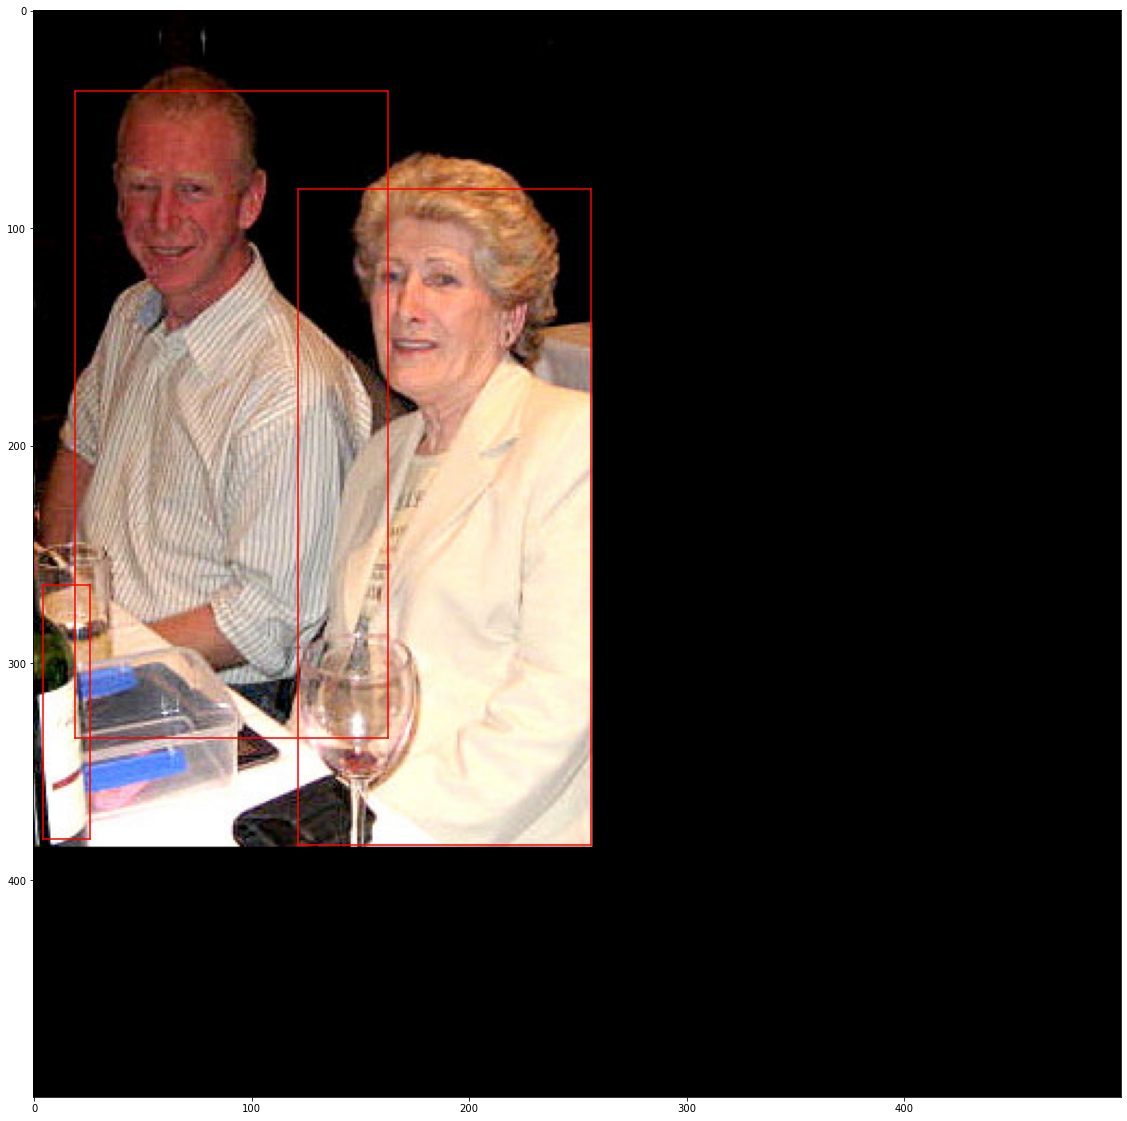

[182.38914 185.72217 230.69969 288.17535]  score :  0.9915003776550293 2008_000403
[178.54164 209.09973 238.02142 301.013  ]  score :  0.9882810711860657 2008_000403
[182.45515 209.0724  197.3841  242.56273]  score :  0.10862860083580017 2008_000403


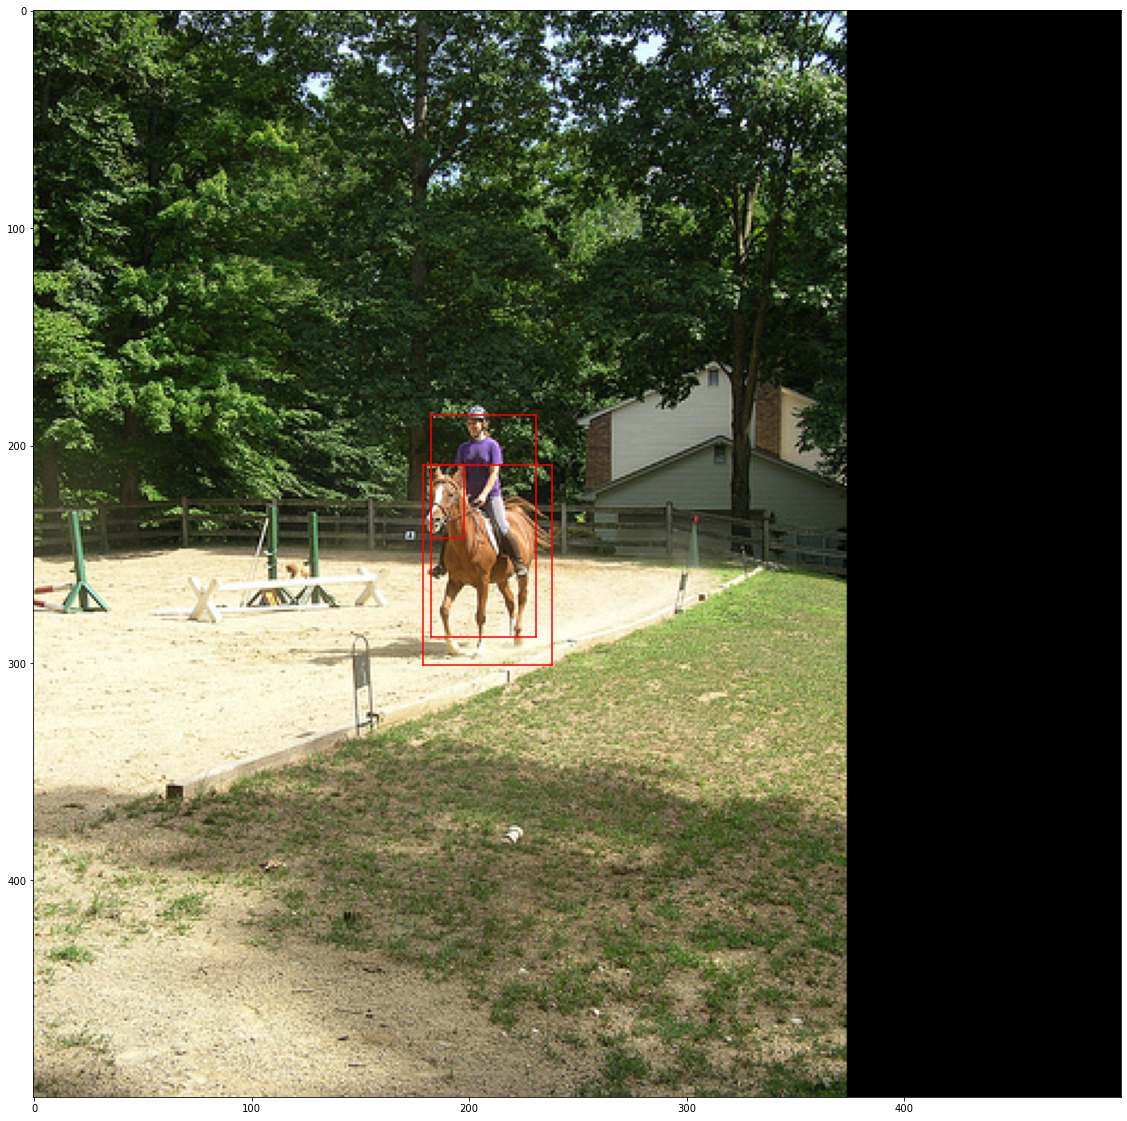

[149.88655  65.44166 436.42133 371.5404 ]  score :  0.9941003918647766 2008_000406
[164.49261  69.67004 307.36163 364.44858]  score :  0.2834263741970062 2008_000406
[158.47038 215.68259 436.56433 369.2636 ]  score :  0.09216111898422241 2008_000406


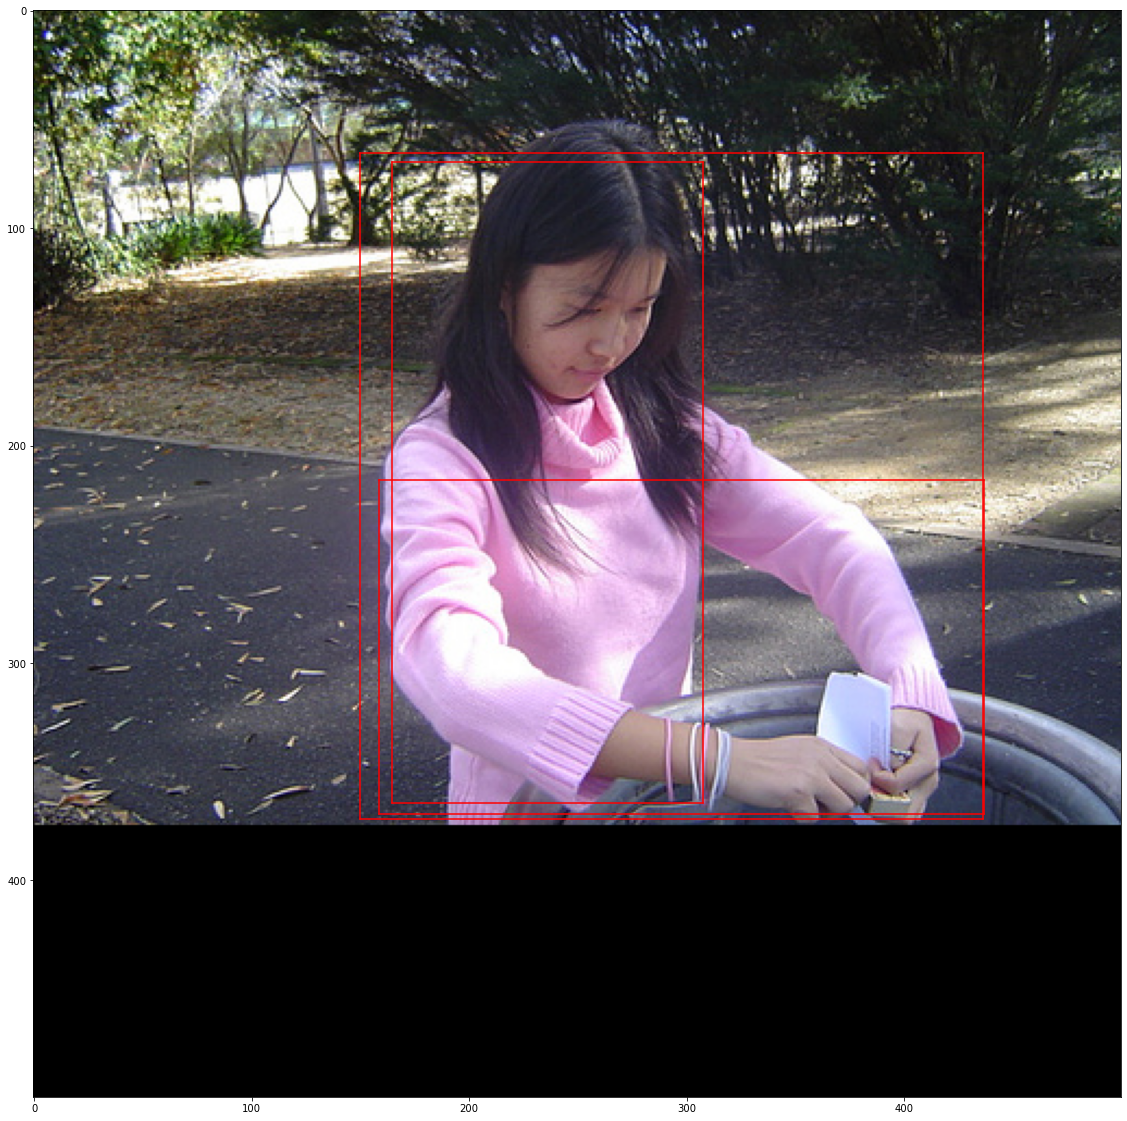

In [17]:
# 加载参数
sd = torch.load('/home/huqian/data/PycharmProjects/Test/sd_fast_r_cnn.pkl')
model.load_state_dict(sd)


# 画框
def plot_box(box,format='r-'):
    xmin = box[0]
    ymin = box[1]
    xmax = box[2]
    ymax = box[3]
    plt.plot([xmin,xmax],[ymin,ymin],format)
    plt.plot([xmin, xmax], [ymax, ymax], format)
    plt.plot([xmin, xmin], [ymin, ymax], format)
    plt.plot([xmax, xmax], [ymin, ymax], format)


# 用测试集评估
model.eval()

i=0
for idx,batch_fn in enumerate(voc_dataset):
    if i<15:
        i+=1
        continue
    if i == 16:
        break
    batch_img, targets = voc_dataset.load(batch_fn)
    output = model(batch_img)

    for idx,o in enumerate(output):
        img = batch_img[idx].cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        plt.figure(figsize=(20,20))
        plt.imshow(img)
        for bpos in range(np.min([3,len(o)])):
            boxes = o['boxes'][bpos].detach().cpu().numpy()
            score = o['scores'][bpos].item()
            print(boxes,' score : ',score,batch_fn[idx])
            plot_box(boxes)
        plt.show()

    i += 1